# Perceptrón Multicapa para Clasificación de Imágenes de MNIST

En este notebook usaremos un Perceptrón Multicapa (o MLP, por sus siglas en inglés) para hacer predicciones sobre imágenes provenientes del célebre conjunto de datos, MNIST.

## Obteniendo los Datos

MNIST es tan conocido en los mundos de deep learning y computer vision que muchos frameworks, tales como Keras, vienen con funciones auxiliares para descargarlo. Por lo tanto, al llamar a esta función, la herramienta se hará cargo no sólo de bajar los datos, sino de dárnoslos divididos en conjuntos de entrenamiento y de prueba. 

In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')

Using TensorFlow backend.


11493376/11490434 [==============================] - 4s 0us/step
Number of training examples: 60000
Number of test examples: 10000


En total, MNIST está compuesta de 70.000 imágenes, de las cuales 60.000 son para entrenar y las 10.000 restantes para probar.

## Visualizando Imágenes de MNIST

Una excelente manera de ganar un entendimiento de los datos con los que estamos lidiando es mirando un par de ejemplos. Hagamos eso:

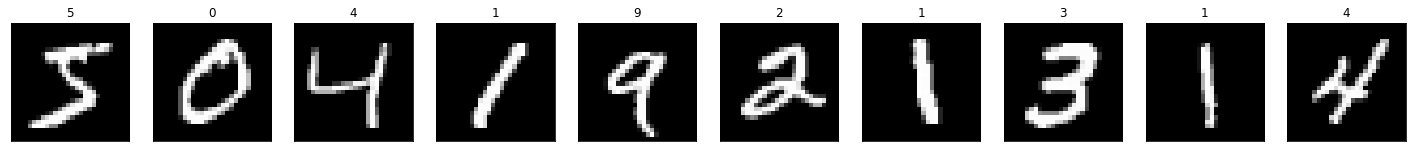

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

SAMPLE_SIZE = 10

# Plot the images in the sample
figure = plt.figure(figsize=(25, 25))

for sample_index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(1, SAMPLE_SIZE, sample_index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[sample_index], cmap='gray')
    ax.set_title(y_train[sample_index])


En el gráfico de arriba observamos varias instancias de los datos. Entre los ejemplos en la muestra, podemos ver que varios corresponden al mismo número, como el 4 y el 1. También podemos detallar que, a pesar de que describen al mismo número, tienen diferencias sutiles. El trabajo de nuestra red, por consiguiente, será capturar estos matices con el fin de predecir el número dibujado en cada imagen.

## Imagen Detallada

Solo para entender mejor lo que la computadora realmente ve, miremos una de éstas imágenes en su forma real: Una matriz.

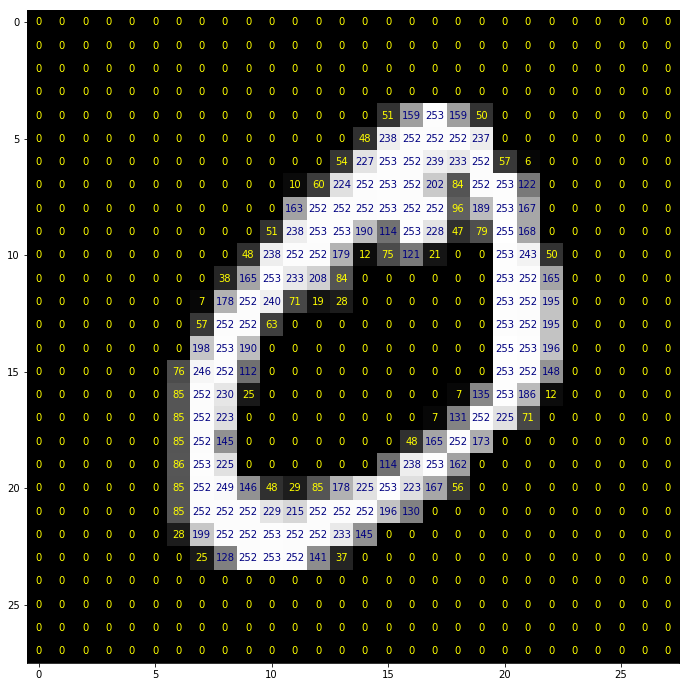

In [3]:
def visualize_input(image, ax):
    ax.imshow(image, cmap='gray')
    width, height = image.shape
    threshold = image.max() / 2.5
    
    for x in range(width):
        for y in range(height):
            pixel_value = image[x][y]
            ax.annotate(f'{round(pixel_value, 2)}', 
                        xy=(y, x),
                       horizontalalignment='center',
                       verticalalignment='center',
                       color='yellow' if pixel_value < threshold else 'navy')
            
SAMPLE_INDEX = 1            
figure = plt.figure(figsize=(12, 12))
ax = figure.add_subplot(111)
visualize_input(X_train[SAMPLE_INDEX], ax)

Los números subyacentes son lo que la computadora realmente ve. Así, el trabajo del MLP será darle sentido a este montón de números y, de alguna forma, entender que se trata de un 0.

## Reescalando las Imágenes

Una buena manera de reescalar una imagen es dividir el valor de cada pixel entre 255, el número más alto que pueden tomar en el espacio de color RGB. Esto hará que cada pixel esté contenido en el rango [0, 1].

In [4]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Codificando Las Etiquetas como Vectores One-hot.

Con la finalidad de romper alguna posible parcialidad con relación al orden de las etiquetas (por ejemplo, que 0 sea interpretado como mejor que 1, 1 mejor que 2, y así sucesivamente), podemos codificar cada etiqueta como un vector one-hot. Esto quiere decir que cada número será convertido a un vector de sólo ceros, a excepción del índice que representa al número, donde habrá un 1. 

0 es representado por [1, 0, 0, 0, 0, 0, 0, 0, 0, 0].

1 es representado por [0, 1, 0, 0, 0, 0, 0, 0, 0, 0].

2 es representado por [0, 0, 2, 0, 0, 0, 0, 0, 0, 0].

.

.

.

9 es representado por [0, 0, 0, 0, 0, 0, 0, 0, 0, 1].

In [5]:
from keras.utils import np_utils

print('Sample of original labels:')
print(y_train[:10])

NUMBER_OF_LABELS = 10
y_train = np_utils.to_categorical(y_train, NUMBER_OF_LABELS)
y_test = np_utils.to_categorical(y_test, NUMBER_OF_LABELS)

print('Sample of one-hot encoded labels:')
print(y_train[:10])

Sample of original labels:
[5 0 4 1 9 2 1 3 1 4]
Sample of one-hot encoded labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Arquitectura del Modelo

Éste es el plato principal de nuestro pequeño proyecto. Definamos una simple red de 3 capas utilizando el API Seuential de Keras.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# Model definition
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(NUMBER_OF_LABELS, activation='softmax'))

# Model summarization
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


¡669.706 parametros para una red tan pequeña! ¡Si son sólo imágenes de 28x28! De hecho, esta resolución es tan baja que las posibilidades de que nos la encontremos en la vida real son mínimas. 

Esto nos da a entender uno de los grandes problemas de los MLPs: Escalabilidad.

## Compilando el Modelo

Ahora que el modelo está definido, podemos compilarlo. Como optimizador, usaremos Adam, el cual es un buen algoritmo por defecto.

La métrica escogida para medir nuestro progreso es la precisión (_accuracy_).

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# _Accuracy_ Sin Entrenar

Solo por curiosidad, veamos qué tal le va a nuestro modelo sin haber siquiera visto la data de entrenamiento. Deberíamos esperar un _accuracy_ aproximado de 10%, similar a lo que obtendríamos adivinando aleatoriamente. 

In [8]:
score = model.evaluate(X_test, y_test)

print(f'Test accuracy: {100 * score[1]}%')

10000/10000 [==============================] - 1s 68us/step
Test accuracy: 11.01%


## Entrenando el Modelo

Entrenemos nuestro MLP. Guardaremos úncamente el modelo con el mejor _accuracy_.

In [9]:
from keras.callbacks import ModelCheckpoint
import os

if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    
OUTPUT_PATH = 'saved_models/mlp.mnist.best.hdf5'
checkpointer = ModelCheckpoint(filepath=OUTPUT_PATH, save_best_only=True)

BATCH_SIZE = 256
EPOCHS = 10
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          epochs=EPOCHS,
                          callbacks=[checkpointer],
                          shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 87us/step - loss: 0.3371 - acc: 0.9009 - val_loss: 0.1337 - val_acc: 0.9597
Epoch 2/10
48000/48000 [==============================] - 4s 80us/step - loss: 0.1238 - acc: 0.9624 - val_loss: 0.0969 - val_acc: 0.9715
Epoch 3/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.0836 - acc: 0.9745 - val_loss: 0.0853 - val_acc: 0.9738
Epoch 4/10
48000/48000 [==============================] - 4s 81us/step - loss: 0.0648 - acc: 0.9793 - val_loss: 0.0836 - val_acc: 0.9747
Epoch 5/10
48000/48000 [==============================] - 4s 80us/step - loss: 0.0510 - acc: 0.9837 - val_loss: 0.0806 - val_acc: 0.9743
Epoch 6/10
48000/48000 [==============================] - 4s 80us/step - loss: 0.0382 - acc: 0.9875 - val_loss: 0.0753 - val_acc: 0.9787
Epoch 7/10
48000/48000 [==============================] - 4s 80us/step - loss: 0.0311 - acc: 0.9900 - val_loss: 0.0809 - val_acc

## Graficando el Historial del _Loss_ y el _Accuracy_

Graficar el progreso del _loss_ y el _accuracy_ es una buena práctica para detectar posibles señales de _underfitting_ u _overfitting_.

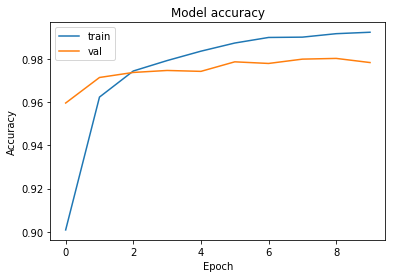

In [10]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

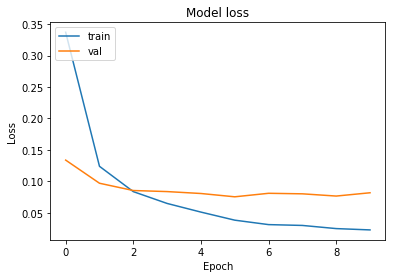

In [11]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Cargando el Mejor Modelo

Carguemos el mejor modelo que haya alcanzado el mejor _accuracy_ en el conjunto de validación para ver cómo se desempeña con data nunca vista.

In [12]:
model.load_weights(OUTPUT_PATH)

In [13]:
score = model.evaluate(X_test, y_test)

print(f'Test accuracy: {100 * score[1]}')

10000/10000 [==============================] - 1s 59us/step
Test accuracy: 97.94
